In [1]:
import pandas as pd
import numpy as np
import os
import sys
import glob

In [2]:
os.chdir('../models')
path = os.getcwd()

In [3]:
rf_dat = pd.read_csv('rf_dat.csv', index_col = 0).reset_index()

In [38]:
coverage = []
coverage.append(len(rf_dat.query('target > prediction -sqrt(Variance) & target < prediction + sqrt(Variance)').index)/len(rf_dat.index))
coverage.append(len(rf_dat.query('target > lower_bound & target < upper_bound').index)/len(rf_dat.index))

In [5]:
import matplotlib.pyplot as plt

In [6]:
d = rf_dat.loc[:500]

In [ ]:
errors = np.array([d['prediction'] - d['lower_bound'], d['upper_bound'] - d['prediction']]).reshape(2, 501)

In [10]:
gbr_dat = pd.read_csv('gbr_dat.csv', index_col = 0).reset_index()

In [39]:
coverage.append(len(gbr_dat.query('target > lower & target < upper').index)/len(gbr_dat.index))
coverage.append(len(gbr_dat.query('target > lower_bound & target < upper_bound').index)/len(gbr_dat.index))

In [45]:
coverage_df = pd.DataFrame(coverage, index = ['rf_jacknife', 'rf_conformal', 'gbr_quantile', 'gbr_conformal'], columns = ['coverage_rate'])

In [11]:
d2 = gbr_dat.loc[:500]

In [12]:
gbr_errors_c = np.array([d2['prediction'] - d2['lower'], d2['upper'] - d2['prediction']])

In [13]:
gbr_errors_q = np.array([d2['prediction'] - d2['lower_bound'], d2['upper_bound'] - d2['prediction']])

# Uncertainty

Imagine you have a flight to catch at 7 PM and you decide that you should arrive at the airport at 5 PM. You look at a map to get an estimate of time to the airport from your home. If it says 25-30 mins you might decide to leave your house around 4:30 PM. If it says 15-90 mins, either because it uses a flawed algorithm or the traffic, you might leave at 4:00 PM.

Data Science as an enterprise has the promise of allowing organizations to make better decisions. This is usually
done by extracting data cuts from business processes and then reducing those data into simple summaries that can
help form decision rules. In many ways the whole purpose of modeling data is to reduce its dimension. This might
sound like a description of Unsupervised Learning but even Supervised Learning is just data reduction in the form
of a dependent or target variable. Sometimes though these simple point summaries can be misleading as they hide
many forms of uncertainty that propagate through the data reduction process. A not exhaustive list of these is
as follows:

- measurement error in the data
- sampling error due to the inherent stochasticity of data collection proceess
- estimation error in the modeling process
- model misspecification error etc.

Hence it is more useful to quantify the uncertainty that is introduced through this process and use interval
estimates instead so that we can still take calculated risks. 

# Three Types of Intervals

- **Confidence Interval**

This is the most commonly taught type of interval in Intro Stats classes. This is a random interval around a 
fixed parameter that promises to trap the parameter within its range with a high probability. It is an inherently
frequentist notion that says that if you build many such intervals they will contain the true parameter value 95%
of the time. However, this assumes a model and offers optimal coverage only asymptotically. Moreover for models 
where we do not know the distribution of the parameters we often have to rely on either extremely expensive
computational tools or very advanced [mathematical statistics theory](https://www.amazon.com/Semiparametric-Theory-Missing-Springer-Statistics/dp/0387324488/ref=sr_1_1?crid=3CQSMW3Y4MNZX&keywords=semiparametric+theory+and+missing+data&qid=1581807438&sprefix=semiparametric+%2Caps%2C155&sr=8-1) to derive these intervals. 

- **Prediction Interval**

This is different from a confidence interval in the following three ways:

1) Unlike confidence intervals it does not assume a model

2) It promises coverage not of the estimator of the expected value of the variable we are interested in 
but of the variable itself. Hence they are usually larger than confidence interval. (Technically they model the
sum of the variance of the expected value, which is the confidence interval, and the expected variability of 
individual observations around that.)

3) They do not offer the guarantee of being asymptotically consistent.

- **Credible Interval**

This is Bayesian counterpart to confidence interval. In the Bayesian paradigm the parameter isn't assumed to be
fixed but is also considered to be a random variable. The interval gives the probability of the parameter falling
within a certain range.

## Getting Prediction Intervals

Below I present four ways of getting intervals for the predicted values from an Ensembled Tree based method:

- **Bootstrap & Cross Validation**

If you use an ensemble with a large number of trees where you let the number of samples falling in each leaf go to
zero you can get a prediction interval for Random Forest prediction by following the procedure below:

   - For each observation make a prediction with each estimator in the ensemble
   - Sort these predictions for each observation to get an CDF
   - Take the 5th and 95th quantile from that CDF and use this as your interval

For cross validation you can do something similar:
  
  - Run many folds of cross validation
  - Collection all predictions for each observation
  - Sort these predictions and take the 5th and 95th quantile
  
As you can see these are extremely expensive computationally and you are using trees that are individually overfit
to form the CDF of your predictions. Hence these intervals are likely to be biased.

- **Quantile Loss to generate intervals**

The bootstrap procedure described above can be used to do this for Random Forests. For Gradient Boosting we can use
the quantile loss function available in Sci-kit Learn. Using this we can make a prediction for the 5th and 95th 
quantile and use those predictions as an interval. 

Both these procedures suffer from either being tied to a particular model or being extremely computationally expensive. A much better option is to use Conformal Prediction.

- **Conformal Prediction Intervals**

This is a much more [general framework](https://arxiv.org/abs/1604.04173) that is not tied to any particular model and can also be used with ensembles
of different models. The procedure is as follows:

   - Split your dataset into a Training, Calibration, Validation Set (for hyperparameter tuning) and Holdout Set.
   
   - Pick a "score" function. For regression the nonconformist package in Python makes available absolute error and signed error. For classification it makes available inverse probability loss and margin loss. But you can code your own score function and use it. 
   
   - After picking a model calculate scores for that model on the calibration set.
   
   - On a new point compute the prediction set which is the model prediction +/- the $q_{1-\alpha}${CDF of the scores from the trainig set}. where $q_{1- \alpha}$ is $1-\alpha$ quantile of the set.
    
It is important to note that the choice of the coverage set will depend heavily on the choice of the model as well
as choice of the scoring function. This is a useful fact and can actually be used to our advantage in model comparison, for example in choosing better calibrated classifiers or regressors. Additionally, it only achives
optimal marginal coverage (predictions belong in the coverage set) and not optimal conditional coverage (prediction
belongs in the coverage set conditional on its covariates). A consequence of only having marginal coverage is that
we might under cover in some portions of the data and over cover in others, especially if we have heteroskedastic
noise. But this is also a useful fact that we can use to our advantage in model checking.

- **Variance Adjusted Infinitesimal Jacknife Interval**

These intervals are motivated by theory and provide **confidence intervals** for Random Forests. [The paper](http://jmlr.org/papers/volume15/wager14a/wager14a.pdf) in
which this method was introduced notes that Random Forest predictions suffer from two kinds of noise:

   - noise due to sampling error
   - noise due to bootstrapping a finite number of times.
    
The authors construct a bias corrected version of the variance of the predictions from a Random Forest model using
the jacknife (drop one observation at a time and note how much a given computed statistic changes) and infinitesimal jacknife (downweight individual observations to see how much the given computed statistic changes) procedures. They have analytical estimates of the bias corrected variance estimates for the predictions and hence
this is the fastest out of all the four methods to compute.

Below are plots showing quantile, conformal and jacknife intervals computer for Random Forest and Gradient Boosting
on a regression problem. The dataset used is the [Superconductivity Dataset](https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data) from the UCI Machine Learning Repository. 


Text(0.5,1,'Jacknife Intervals for Random Forest')

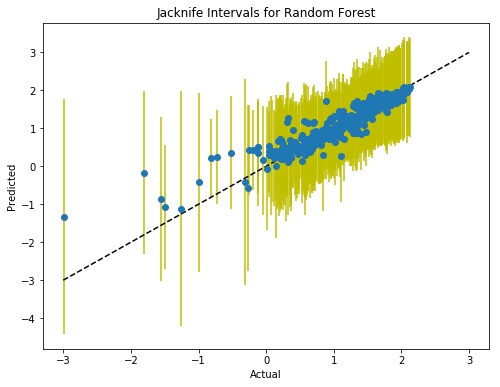

In [56]:
plt.figure(figsize = (8, 6))
plt.errorbar(d['target'], d['prediction'], yerr = np.sqrt(d['Variance']), fmt = 'o', ecolor = 'y')
plt.plot([-3, 3], [-3, 3], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Jacknife Intervals for Random Forest')

Text(0.5,1,'Conformal Interval for Random Forest')

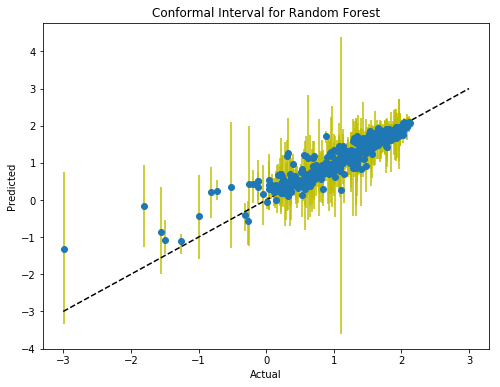

In [58]:
plt.figure(figsize = (8, 6))
plt.errorbar(d['target'], d['prediction'], yerr = errors, fmt = 'o', ecolor = 'y')
plt.plot([-3, 3], [-3, 3], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Conformal Interval for Random Forest')

Text(0.5,1,'Quantile Interval for Gradient Boosting')

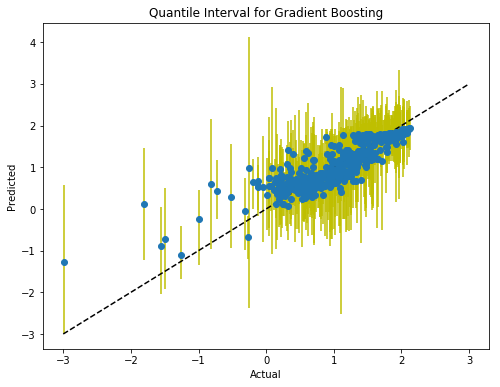

In [60]:
plt.figure(figsize = (8, 6))
plt.errorbar(d2['target'], d2['prediction'], yerr = gbr_errors_q, fmt = 'o', ecolor = 'y')
plt.plot([-3, 3], [-3, 3], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Quantile Interval for Gradient Boosting')

Text(0.5,1,'Conformal Interval for Gradient Boosting')

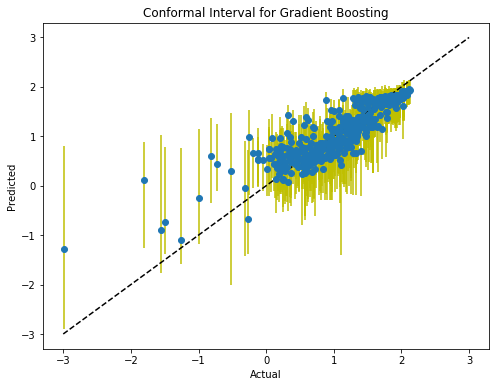

In [61]:
plt.figure(figsize = (8, 6))
plt.errorbar(d2['target'], d2['prediction'], yerr = gbr_errors_c, fmt = 'o', ecolor = 'y')
plt.plot([-3, 3], [-3, 3], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Conformal Interval for Gradient Boosting')

We can see how useful these intervals are by calculating how frequently they capture the true value within their range. Below are the computed coverage rates for the four intervals:

In [46]:
coverage_df

,coverage_rate
rf_jacknife,0.994827
rf_conformal,0.905941
gbr_quantile,0.844960
gbr_conformal,0.941370


Jacknife intervals achieve the best coverage rate but they can only be used with Random Forest. Conformal Intervals
do much better than quantile intervals and can be used with any base model. Moreoever they are much cheaper to
compute than bootstrap and cross validation intervals. They're also excellent to use for classification problems
and can achieve much better calibration for your classifier by reducing false positives and false negatives.

All the code used for this post is available on this [github repository](https://github.com/vonarchimboldi/Projects/tree/master/mlprojects/mlframework).